# Study 1. Predicción de series temporales (Sin Indicadores)

En este estudio revisaré el 'score' del modelo definido sin tener en cuenta los indicadores técnicos de la librería TA-Lib y evaluar así, si realmente influyen en las predicciones del modelo, ya que anteriormente vi, que dichos indicadores tenían una baja correlación con las salidas predichas-objetivo.


### Cargo librerías

In [1]:
####################################################################################
# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
from pandas.plotting import scatter_matrix
import numpy as np

####################################################################################
# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, KFold
import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

####################################################################################
# Librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls
tls.set_credentials_file(username='raulMrello', api_key='qX9S30YRQ866mGF9b89u')

####################################################################################
# TA-Lib: instalación y carga de la librería
import talib

####################################################################################
# Otras utilidades
import datetime
import time
import os
import sys
import math

Using TensorFlow backend.


In [2]:
import MyUtils as utils
print('Ready!')

Ready!


### Obtengo el histórico de precios OHLC

In [5]:
# Cargo el histórico en el dataframe 'df' y visualizo los primeros registros
df = utils.load_hist('EURUSD_H1.csv', sep=';', remove_weekends=True)
df = df[['OPEN','HIGH','LOW','CLOSE','OC2','HLC3','OHLC4']]
df.head()


Deleting weekends...


,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4
2001-01-01 01:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205
2001-01-01 02:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205
2001-01-01 03:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205
2001-01-01 04:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205
2001-01-01 05:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205


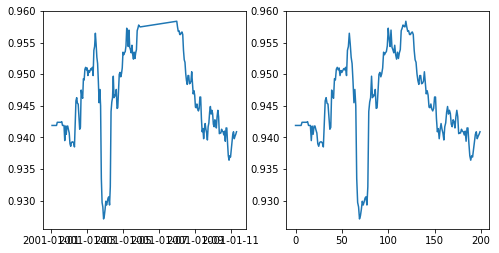

In [6]:
# Visualizo los 200 primeros datos del precio de cierre (CLOSE) de dos formas:
# Utilizando el eje x como fechas espaciadas de hora en hora (se ve un ajuste a mitad de gráfico debido a un fin de semana)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(df.CLOSE[0:200])
# Utilizando los datos en bruto, con lo que dicha 'perturbación' ya no queda reflejada y por lo tanto podemos ver que los datos
# son válidos.
plt.subplot(1,2,2)
plt.plot(df.CLOSE.values[0:200])

### Preparo las salidas a predecir

In [7]:
# función para generar las salidas a predecir
def define_outputs(df):  
  df['OUT_HIGH'] = df.HIGH - df.CLOSE.shift(1)
  df['OUT_LOW'] = df.LOW - df.CLOSE.shift(1)
  return df

# Añado las salidas a predecir al dataframe 'df'
df = define_outputs(df)
df.dropna(inplace=True)
df.head()

,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,OUT_HIGH,OUT_LOW
2001-01-01 02:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0004,0.0
2001-01-01 03:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0004,0.0
2001-01-01 04:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0004,0.0
2001-01-01 05:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0004,0.0
2001-01-01 06:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0004,0.0


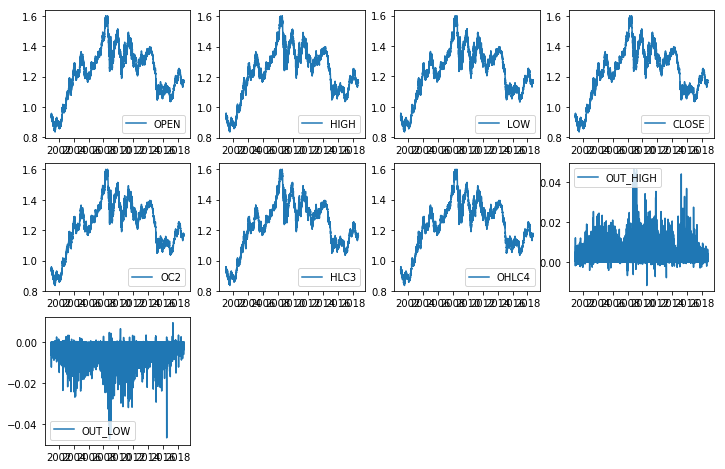

In [9]:
# Visualizo gráficamente todos los 'features' que forman el dataframe 'df', incluyendo las salidas a predecir
rows = (df.shape[1] / 4) + 1
plt.figure(figsize = (12,8))
for c in df.columns:
  i = df.columns.get_loc(c)+1
  plt.subplot(rows, 4, i)
  plt.plot(df[c])
  plt.legend([c])
  

### Adaptación de los datos al modelo neuronal

In [10]:
# Defino el formato del dataframe 'df_nn' que voy a obtener como proceso de adaptación. Es necesario definir las siguientes
# variables que se utilizarán a lo largo del desarrollo

# Número de salidas a predecir
num_outputs = 2

# Número de 'features' de entrada
num_inputs = len(df.columns) - num_outputs

# Número de timesteps previos
n_in = 4

# Número de timesteps a futuro
n_out = 1

# Flag para eliminar NaNs del dataframe resultante tras aplicar la adaptación
dropnan = True

# Procesa la adaptación al dataframe 'df' y genera un nuevo dataframe 'df_nn'
df_nn = utils.series_to_supervised(df, num_inputs, num_outputs, n_in, n_out, dropnan)
print(df_nn.shape)
df_nn.head()

(111115, 30)


,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),OPEN(t-2),HIGH(t-2),LOW(t-2),...,OHLC4(t-1),OPEN(t),HIGH(t),LOW(t),CLOSE(t),OC2(t),HLC3(t),OHLC4(t),OUT_HIGH(t+1),OUT_LOW(t+1)
2001-01-01 05:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.9421,0.9423,0.9419,...,0.94205,0.9421,0.9423,0.9419,0.9419,0.9420,0.942033,0.94205,0.0004,0.0000
2001-01-01 06:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.9421,0.9423,0.9419,...,0.94205,0.9421,0.9423,0.9419,0.9419,0.9420,0.942033,0.94205,0.0004,0.0000
2001-01-01 07:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.9421,0.9423,0.9419,...,0.94205,0.9421,0.9423,0.9419,0.9419,0.9420,0.942033,0.94205,0.0005,0.0003
2001-01-01 08:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.9421,0.9423,0.9419,...,0.94205,0.9422,0.9424,0.9422,0.9424,0.9423,0.942333,0.94230,0.0000,-0.0002
2001-01-01 09:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.9421,0.9423,0.9419,...,0.94230,0.9422,0.9424,0.9422,0.9424,0.9423,0.942333,0.94230,0.0000,-0.0002


In [11]:
# chequeo que la generación de las salidas a predecir es correcta mediante un dataframe temporal '_df' con las columnas más
# representativas. Verificaré que la columna 'next_high' coincide con 'HIGH(t)' desplazada 1 sesión en el futuro
_df = df_nn[['HIGH(t-1)','HIGH(t)','LOW(t-1)','LOW(t)','CLOSE(t-1)', 'CLOSE(t)','OUT_HIGH(t+1)']].head(10).copy()
_df['next_high'] = _df['CLOSE(t)']+ _df['OUT_HIGH(t+1)']
_df

,HIGH(t-1),HIGH(t),LOW(t-1),LOW(t),CLOSE(t-1),CLOSE(t),OUT_HIGH(t+1),next_high
2001-01-01 05:00:00,0.9423,0.9423,0.9419,0.9419,0.9419,0.9419,0.0004,0.9423
2001-01-01 06:00:00,0.9423,0.9423,0.9419,0.9419,0.9419,0.9419,0.0004,0.9423
2001-01-01 07:00:00,0.9423,0.9423,0.9419,0.9419,0.9419,0.9419,0.0005,0.9424
2001-01-01 08:00:00,0.9423,0.9424,0.9419,0.9422,0.9419,0.9424,0.0000,0.9424
2001-01-01 09:00:00,0.9424,0.9424,0.9422,0.9422,0.9424,0.9424,0.0000,0.9424
2001-01-01 10:00:00,0.9424,0.9424,0.9422,0.9422,0.9424,0.9424,0.0000,0.9424
2001-01-01 11:00:00,0.9424,0.9424,0.9422,0.9422,0.9424,0.9424,0.0000,0.9424
2001-01-01 12:00:00,0.9424,0.9424,0.9422,0.9422,0.9424,0.9424,0.0000,0.9424
2001-01-01 13:00:00,0.9424,0.9424,0.9422,0.9422,0.9424,0.9424,0.0001,0.9425
2001-01-01 14:00:00,0.9424,0.9425,0.9422,0.9425,0.9424,0.9425,-0.0006,0.9419


### Normalización de los datos

In [12]:
#### Normalización de los datos sobre el datafram 'df_nn'. Genero un nuevo dataframe 'dfnorm'
dfnorm, scaler = utils.normalize_data(df_nn)
# Verifico los datos del nuevo dataframe generado
dfnorm.describe()

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),OPEN(t-2),HIGH(t-2),LOW(t-2),...,OHLC4(t-1),OPEN(t),HIGH(t),LOW(t),CLOSE(t),OC2(t),HLC3(t),OHLC4(t),OUT_HIGH(t+1),OUT_LOW(t+1)
count,111115.000000,111115.000000,111115.000000,111115.000000,111115.000000,111115.000000,111115.000000,111115.000000,111115.000000,111115.000000,...,111115.000000,111115.000000,111115.000000,111115.000000,111115.000000,111115.000000,111115.000000,111115.000000,111115.000000,111115.000000
mean,0.033592,0.032959,0.034945,0.033591,0.034686,0.034882,0.034965,0.033598,0.032964,0.034950,...,0.034975,0.033608,0.032974,0.034961,0.033607,0.034702,0.034897,0.034980,-0.548023,0.615993
std,0.417237,0.416688,0.417489,0.417124,0.417776,0.417688,0.417737,0.417232,0.416683,0.417483,...,0.417725,0.417220,0.416671,0.417472,0.417107,0.417759,0.417671,0.417720,0.062079,0.063137
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.239768,-0.240193,-0.238294,-0.239705,-0.239074,-0.238788,-0.238732,-0.239754,-0.240193,-0.238294,...,-0.238705,-0.239754,-0.240167,-0.238294,-0.239666,-0.239054,-0.238771,-0.238705,-0.578315,0.607300
50%,0.090766,0.089847,0.092205,0.090743,0.091932,0.092186,0.092252,0.090766,0.089847,0.092205,...,0.092252,0.090766,0.089847,0.092205,0.090743,0.091932,0.092186,0.092252,-0.564591,0.633269
75%,0.324540,0.322807,0.326668,0.324337,0.326010,0.326102,0.326234,0.324540,0.322807,0.326668,...,0.326234,0.324540,0.322807,0.326668,0.324337,0.326010,0.326102,0.326234,-0.540573,0.647658
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Validación cruzada

In [13]:
# split into input (X) and output (Y) variables
X = dfnorm.values[:,:(num_inputs*n_in)]
Y = dfnorm.values[:,(num_inputs*n_in):]
# define 5-fold cross validation test harness
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
i=0
for train, test in kfold.split(X, Y):
  # create model
  model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 3,2,64,128,'weights_2711_m'+str(i)+'.hd5')
  i += 1
  # Fit the model
  x = X[train]
  x = x.reshape(x.shape[0], n_in, num_inputs)
  utils.fit(model, x, Y[train], num_inputs, n_in, num_epochs=5, callbacks=callbacks, batchsize=32)  
  # evaluate the model
  x = X[test]
  scores = utils.test_evaluation(model, x, Y[test], num_inputs, n_in)
  x = x.reshape(x.shape[0], n_in, num_inputs)
  scores = model.evaluate(x, Y[test], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/5
 - 16s - loss: 0.0049 - acc: 0.9996
Epoch 2/5


C:\Users\raulm\Programas\anaconda3\envs\keras\lib\site-packages\keras\callbacks.py:434: RuntimeWarning:

Can save best model only with val_acc available, skipping.



 - 15s - loss: 0.0038 - acc: 0.9997
Epoch 3/5
 - 15s - loss: 0.0038 - acc: 0.9997
Epoch 4/5
 - 15s - loss: 0.0038 - acc: 0.9997
Epoch 5/5
 - 15s - loss: 0.0038 - acc: 0.9997
loss: 0.42%
acc: 99.99%
Epoch 1/5
 - 17s - loss: 0.0048 - acc: 0.9997
Epoch 2/5
 - 15s - loss: 0.0038 - acc: 0.9998
Epoch 3/5
 - 15s - loss: 0.0038 - acc: 0.9998
Epoch 4/5
 - 15s - loss: 0.0038 - acc: 0.9998
Epoch 5/5
 - 15s - loss: 0.0038 - acc: 0.9998
loss: 0.45%
acc: 99.96%
Epoch 1/5
 - 17s - loss: 0.0047 - acc: 0.9997
Epoch 2/5
 - 16s - loss: 0.0037 - acc: 0.9998
Epoch 3/5
 - 16s - loss: 0.0037 - acc: 0.9998
Epoch 4/5
 - 16s - loss: 0.0037 - acc: 0.9998
Epoch 5/5
 - 16s - loss: 0.0037 - acc: 0.9998
loss: 0.47%
acc: 99.96%
Epoch 1/5
 - 18s - loss: 0.0049 - acc: 0.9994
Epoch 2/5
 - 16s - loss: 0.0038 - acc: 0.9998
Epoch 3/5
 - 16s - loss: 0.0038 - acc: 0.9998
Epoch 4/5
 - 16s - loss: 0.0038 - acc: 0.9998
Epoch 5/5
 - 16s - loss: 0.0038 - acc: 0.9998
loss: 0.42%
acc: 99.98%
Epoch 1/5
 - 17s - loss: 0.0048 - acc: 0

### Entrenamiento del modelo

In [14]:
# Preparo los conjuntos de entrenamiento y validación en una proporción del 80-20
x_train,y_train,x_test,y_test = utils.prepare_training_data(dfnorm, num_inputs * n_in, 0.8)
print('x_train:', x_train.shape, 'y_train', y_train.shape)
print('x_test:', x_test.shape, 'y_test', y_test.shape)


x_train: (88892, 28) y_train (88892, 2)
x_test: (22223, 28) y_test (22223, 2)


In [15]:
# Creo el mismo modelo neuronal utilizado durante la validación  cruzada
model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 3,2,64,128,'weights_study_1.hd5')

Train on 71113 samples, validate on 17779 samples
Epoch 1/10
 - 15s - loss: 0.0062 - acc: 0.9995 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 2/10
 - 13s - loss: 0.0047 - acc: 0.9997 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 3/10
 - 13s - loss: 0.0047 - acc: 0.9997 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 4/10
 - 15s - loss: 0.0047 - acc: 0.9997 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 5/10
 - 15s - loss: 0.0046 - acc: 0.9997 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 6/10
 - 14s - loss: 0.0046 - acc: 0.9997 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 7/10
 - 13s - loss: 0.0046 - acc: 0.9997 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 8/10
 - 13s - loss: 0.0046 - acc: 0.9997 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 9/10
 - 13s - loss: 0.0046 - acc: 0.9997 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 10/10
 - 13s - loss: 0.0046 - acc: 0.9997 - val_loss: 0.0034 - val_acc: 1.0000


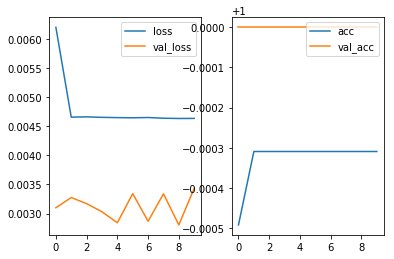

In [16]:
# Realizo el proceso de entrenamiento durante un número de épocas.
num_epochs = 10
# Tamaño del batch para la actualización de pesos
batchsize = 32
# Utilizo un 20% de los datos para realizar una validación
val_ratio = 0.2
# Cojo datos de forma aleatoria durante la fase de entrenamiento
shuffle = True
# Flag para visualizar los resultados al final del proceso
plot_results = True
# Función para iniciar el entrenamiento
result = utils.fit(model, x_train, y_train, num_inputs, n_in, num_epochs, callbacks, batchsize, val_ratio, shuffle, plot_results)

In [17]:
# Guardo los pesos en un archivo HDF5
model.save_weights('weights_study_1.hd5')

### Verificación del modelo

Model Loss:  0.003065966119827548
Model Accuracy:  0.9997750078747244


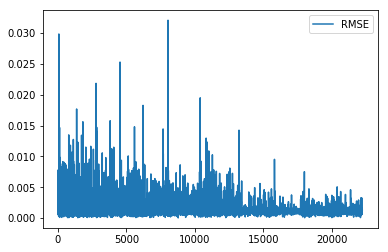

In [18]:
# Evaluación del modelo con la partición de test. Utilizo callback para formar las salidas reales
ih = df_nn.columns.get_loc('OUT_HIGH(t+1)')  
il = df_nn.columns.get_loc('OUT_LOW(t+1)')
ic = df_nn.columns.get_loc('CLOSE(t)')
  
def out_builder(xy,xyhat):
  return np.asarray([xy[ih]+xy[ic],xy[il]+xy[ic]]), np.asarray([xyhat[ih]+xyhat[ic],xyhat[il]+xyhat[ic]])
  
scores, targets, preds, rmse = utils.test_rmse(model, x_test, y_test, num_inputs, n_in, num_outputs, n_out, scaler, out_builder, True)

In [20]:
df_nn.head(1)

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),OPEN(t-2),HIGH(t-2),LOW(t-2),...,OHLC4(t-1),OPEN(t),HIGH(t),LOW(t),CLOSE(t),OC2(t),HLC3(t),OHLC4(t),OUT_HIGH(t+1),OUT_LOW(t+1)
2001-01-01 05:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.9421,0.9423,0.9419,...,0.94205,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0004,0.0


In [22]:
# obtengo los resultados como arrays
atgt = np.asarray(targets)
apreds = np.asarray(preds)
armse = np.asarray(rmse)

nrmse = armse/(max(df_nn['HIGH(t)'].max(), df_nn['LOW(t)'].max()) - min(df_nn['HIGH(t)'].min(), df_nn['LOW(t)'].min()))

# creo un nuevo dataframe de resultados 'df_predict'
df_predict = df_nn[x_train.shape[0]:].copy()
#... al que añado las predicciones hechas...
df_predict['PREDICT_HIGH'] = apreds[:,0]
df_predict['PREDICT_LOW'] = apreds[:,1]

#... los objetivos que debería haber predicho...
df_predict['TARGET_HIGH'] = df_predict['CLOSE(t)'] + df_predict['OUT_HIGH(t+1)'] 
df_predict['TARGET_LOW'] = df_predict['CLOSE(t)'] + df_predict['OUT_LOW(t+1)'] 

#... unas columnas para chequear que los objetivos son correctos
df_predict['TARGET_HIGH_CHECK'] = atgt[:,0]
df_predict['TARGET_LOW_CHECK'] = atgt[:,1]

#... el error RMSE
df_predict['RMSE'] = armse[:]
df_predict['NRMSE'] = nrmse[:]

df_predict.head()

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),OPEN(t-2),HIGH(t-2),LOW(t-2),...,OUT_HIGH(t+1),OUT_LOW(t+1),PREDICT_HIGH,PREDICT_LOW,TARGET_HIGH,TARGET_LOW,TARGET_HIGH_CHECK,TARGET_LOW_CHECK,RMSE,NRMSE
2015-03-13 01:00:00,1.06179,1.06394,1.06178,1.06334,1.062565,1.063020,1.062712,1.06335,1.06335,1.06218,...,0.00005,-0.00185,1.064428,1.061189,1.06267,1.06077,1.06267,1.06077,0.001278,0.001661
2015-03-13 02:00:00,1.06335,1.06335,1.06218,1.06241,1.062880,1.062647,1.062823,1.06325,1.06346,1.04623,...,0.00069,-0.00010,1.062587,1.059349,1.06147,1.06068,1.06147,1.06068,0.001229,0.001597
2015-03-13 03:00:00,1.06325,1.06346,1.04623,1.06221,1.062730,1.057300,1.058787,1.06221,1.06283,1.06216,...,0.00052,-0.00032,1.062697,1.059459,1.06141,1.06057,1.06141,1.06057,0.001202,0.001563
2015-03-13 04:00:00,1.06221,1.06283,1.06216,1.06262,1.062415,1.062537,1.062455,1.06266,1.06267,1.06077,...,0.00061,-0.00035,1.063007,1.059769,1.06181,1.06085,1.06181,1.06085,0.001140,0.001482
2015-03-13 05:00:00,1.06266,1.06267,1.06077,1.06078,1.061720,1.061407,1.061720,1.06079,1.06147,1.06068,...,0.00000,-0.00129,1.063187,1.059950,1.06138,1.06009,1.06138,1.06009,0.001281,0.001666


Con el nuevo dataframe de resultado 'df_predict', realizo una visualización para ver cómo se ha comportado el modelo.

Visualizaré un rango de datos (i:j) de los objetivos H,L buscados y las predicciones reales generadas. El área entre los objetivos H-L se rellenerá en color gris, mientras que el área de las predicciones se rellenará en amarillo.

De esta forma, se puede ver claramente, si el rango de predicción es correcto y está alineado con el objetivo.

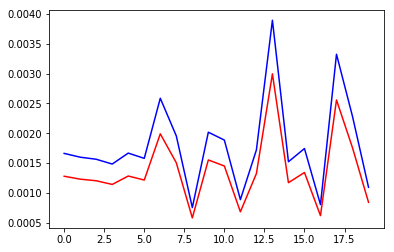

In [26]:
plt.plot(armse[0:20], color = 'r')
plt.plot(nrmse[0:20], color = 'b')

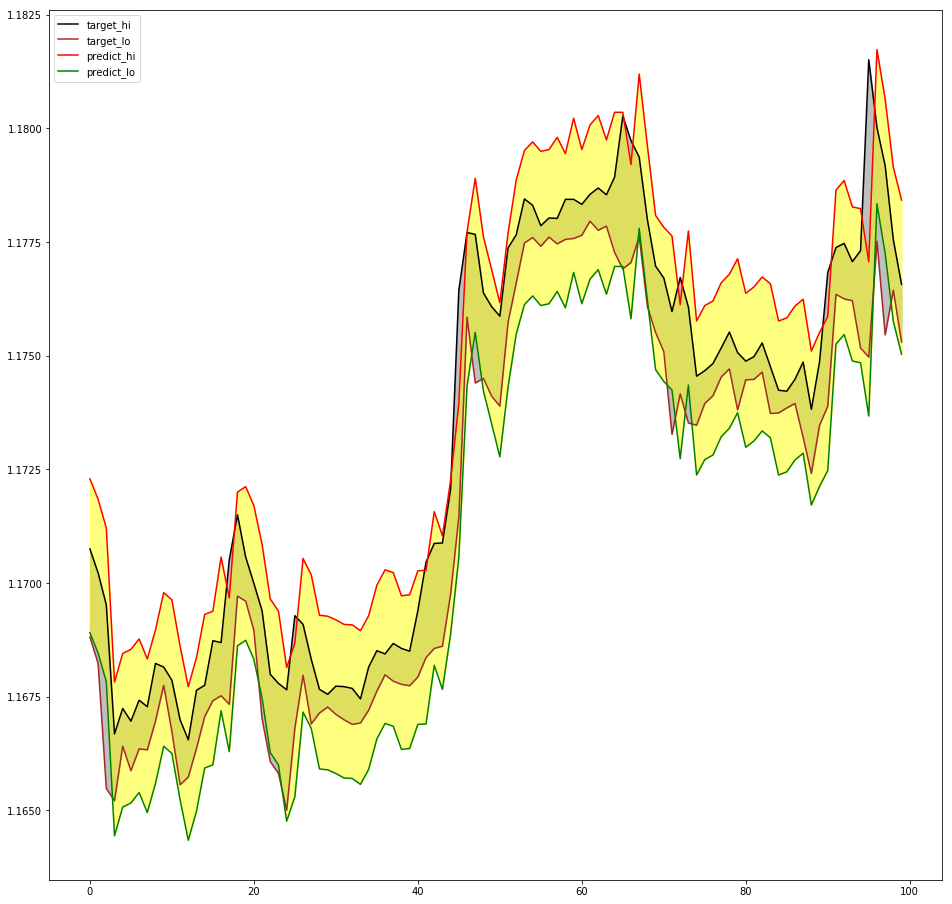

In [29]:
plt.figure(figsize=(16,16))
i,j=-200,-100
x = np.arange(j-i)
y1 = df_predict['TARGET_HIGH'].values[i:j]
y2 = df_predict['TARGET_LOW'].values[i:j]
y3 = df_predict['PREDICT_HIGH'].values[i:j]
y4 = df_predict['PREDICT_LOW'].values[i:j]
plt.plot(x,y1, color='black')
plt.plot(x,y2, color = 'brown')
plt.plot(x,y3, color = 'red')
plt.plot(x,y4, color = 'green')
plt.legend(['target_hi','target_lo', 'predict_hi', 'predict_lo'])
plt.fill_between(x,y1,y2, color='grey', alpha='0.5')
plt.fill_between(x,y3,y4, color='yellow', alpha='0.5')
#plt.plot(df_predict['TARGET_HIGH_CHECK'].values[i:j])
#plt.plot(df_predict['TARGET_LOW_CHECK'].values[i:j])


## 4 Conclusiones


Como puede observarse, si comparamos el resultado de este modelo con el que utiliza indicadores técnicos, vemos que es menos preciso, ya que genera rangos H,L más anchos.